In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [2]:
theta0=np.radians(20)
df_comp = pd.read_csv(f'stab_analysis/compromise_20.0theta0_big.csv')
df_dec = pd.read_csv(f'stab_analysis/decision_20.0theta0_big.csv')

In [3]:
t1 = df_comp['theta1'].values
t2 = df_comp['theta2'].values

for i in range(len(t1)):
    # Convert string to array
    t1[i] = np.fromstring(t1[i][1:-1], sep=' ')
    t2[i] = np.fromstring(t2[i][1:-1], sep=' ')
    
    # Boolean mask of non-NaN elements
    mask = ~np.isnan(t1[i]) & ~np.isnan(t2[i])

    # New arrays with only non-NaN elements
    t1[i] = t1[i][mask]
    t2[i] = t2[i][mask]

  # put nan in empty arrays
    if len(t1[i])==0:
        t1[i] = np.nan
    else:
      t1[i] = t1[i][0]
    if len(t2[i])==0:
      t2[i] = np.nan
    else:
      t2[i] = t2[i][0]

# put t1 and t2 as columns in df 
df_comp['theta1'] = t1
df_comp['theta2'] = t2

In [4]:
# stab comp
def Jacobian(theta1, theta2, k, omega1, omega2):
    '''
    Jacobian matrix 
    '''
    return np.array([[-k*np.cos(theta1-theta2) - np.cos(theta1 - omega1), k*np.cos(theta1-theta2)], [k*np.cos(theta1-theta2), -k*np.cos(theta1-theta2) - np.cos(theta2 - omega2)]])

def is_stable(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are stable.
    Return True if they are stable, False otherwise.
    '''
    J = Jacobian(theta1, theta2, k, omega1, omega2)
    # check first element of J is positive and the determinant of J is positive
    #return (J[0,0]>0) and (np.linalg.det(J)>0)
    # check if the real part of the eigenvalues is negative
    return np.all(np.real(np.linalg.eigvals(J))<0)

df_comp = df_comp.dropna()
df_comp['stable'] = df_comp.apply(lambda row: is_stable(row['theta1'], row['theta2'], row['K'], row['omega1'], row['omega2']), axis=1)

In [5]:
# ADD ALSO THETA2 SOLUTIONS

df_dec_modified = df_dec.copy()
# Find the rows where theta1 and theta2 are not NaN
mask = ~df_dec_modified[['theta1', 'theta2']].isnull().any(axis=1)
# Create the new rows
new_rows = df_dec_modified[mask].copy()
new_rows['theta1'] = new_rows['omega2']
new_rows['theta2'] = new_rows['omega2']
# Append the new rows to the dataframe
df_dec_modified = df_dec_modified.append(new_rows, ignore_index=True)
df_dec = df_dec_modified

In [7]:
K_value = 3.1

df_K_comp = df_comp[np.isclose(df_comp['K'], K_value, atol=1e-2)]
df_K_dec = df_dec[np.isclose(df_dec['K'], K_value, atol=1e-2)]

In [8]:
# RESCALING TO HAVE SYMMETRY ALONG X AXIS
def transform(df):
    df_copy = df.copy()
    df_copy['theta1'] -= df['omega1']/2
    df_copy['theta2'] -= df['omega1']/2
    df_copy['omega1'] -= df['omega1']/2
    df_copy['omega2'] -= df['omega1']/2
    return df_copy

df_K_comp = transform(df_K_comp)
df_K_dec = transform(df_K_dec)


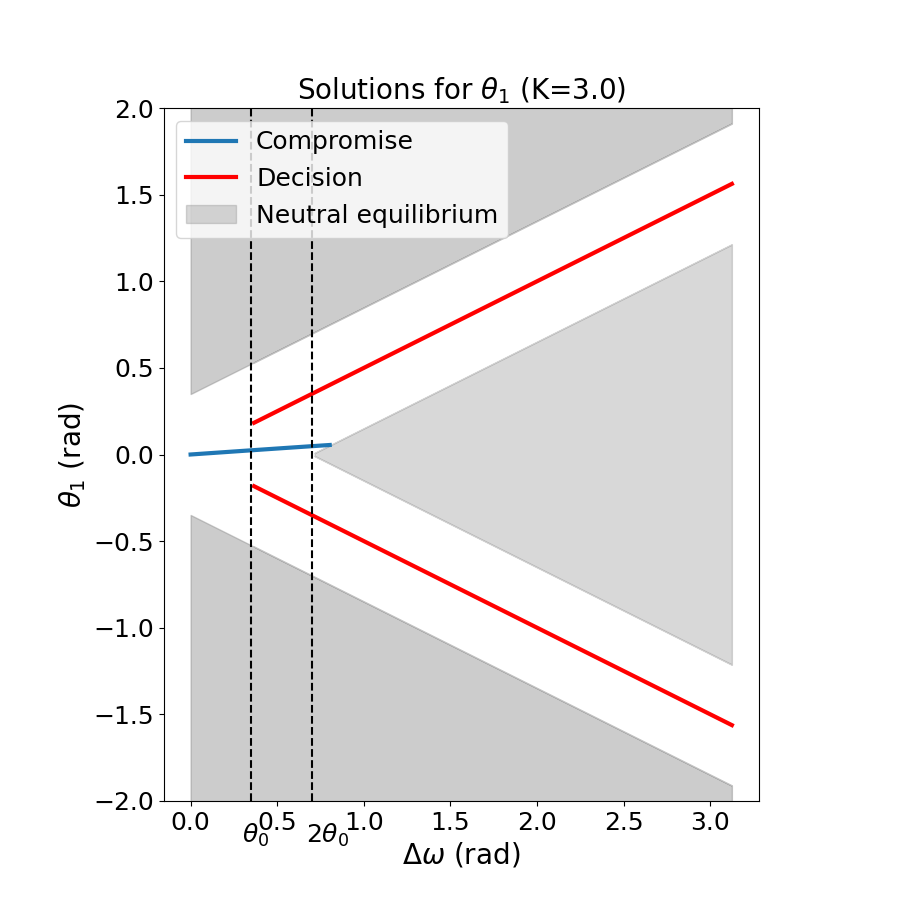

In [9]:
# Plot theta1 over omega_diff for both datasets
plt.figure(figsize=(9, 9))

plt.plot(df_K_comp[df_K_comp['stable']==True]['omega_diff'], df_K_comp[df_K_comp['stable']==True]['theta1'], label=r'Compromise', lw=3, c='C0')
plt.plot(df_K_dec[df_K_dec['theta1']>0]['omega_diff'], df_K_dec[df_K_dec['theta1']>0]['theta1'], label='Decision', lw=3, c='red')
plt.plot(df_K_dec[df_K_dec['theta1']<0]['omega_diff'], df_K_dec[df_K_dec['theta1']<0]['theta1'], lw=3, c='red')

plt.title(rf"Solutions for $\theta_1$ (K={round(K_value,0)})", fontsize=20)
plt.xlabel(r'$\Delta\omega$ (rad)', fontsize=20)
plt.ylabel(r'$\theta_1$ (rad)', fontsize=20)

# plt.plot(df_K_dec[df_K_dec['omega_diff']>np.radians(40)]['omega_diff'], df_K_dec[df_K_dec['omega_diff']>np.radians(40)]['omega1']-theta0, c='black', lw=1, ls='--')
# plt.plot(df_K_dec['omega_diff'], df_K_dec['omega1']+theta0, c='black', lw=1, ls='--')
# plt.plot(df_K_dec['omega_diff'], df_K_dec['omega2']-theta0, c='black', lw=1, ls='--')
# plt.plot(df_K_dec[df_K_dec['omega_diff']>np.radians(40)]['omega_diff'], df_K_dec[df_K_dec['omega_diff']>np.radians(40)]['omega2']+theta0, c='black', lw=1, ls='--')

# # Define the lines forming the triangle
line1 = df_K_dec['omega1']-theta0
line2 = df_K_dec['omega2']+theta0

line3 = df_K_dec['omega1']+theta0
line4 = np.full(len(df_K_dec['omega_diff']), np.pi)

line5 = df_K_dec['omega2']-theta0
line6 = np.full(len(df_K_dec['omega_diff']), -np.pi)

mask = df_K_dec['omega_diff'] > 2*theta0
# Fill the region between the lines
plt.fill_between(df_K_dec['omega_diff'][mask], line1[mask], line2[mask], color='gray', alpha=0.3, label='Neutral equilibrium')
plt.fill_between(df_K_dec['omega_diff'], line3, line4, color='gray', alpha=0.4)
plt.fill_between(df_K_dec['omega_diff'], line5, line6, color='gray', alpha=0.4)

#set limits
# plt.xlim(0, np.radians(60))
plt.ylim(-2, 2)

# set vertical line at 20
plt.axvline(x=np.radians(20), ls='--', c='black')
plt.axvline(x=np.radians(40), ls='--', c='black')

plt.text(np.radians(17), -2.24, rf'$\theta_0$', fontsize=18, rotation=0)
plt.text(np.radians(38), -2.24, rf'$2\theta_0$', fontsize=18, rotation=0)

# tick size both axes
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18, loc='upper left')
# plt.grid(True)
# set same aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# save figure
plt.savefig(f'../img/theta1_K_{K_value}.pdf', dpi=300, bbox_inches='tight')
